In [ ]:
!pip install pymysql

In [ ]:
import pymysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import datetime

In [ ]:
import seaborn as sns

In [ ]:

pd.set_option('display.max_column', None)
pd.set_option('display.max_rows', None)

In [ ]:
e='RDS link'
u='user name'
p='password'
db='daatabase LINK'
connection=pymysql.connect(host=e,user=u,passwd=p,db=db)

In [ ]:
cursors=connection.cursor()
cursors.execute("""select *,date_format(CONVERT_TZ(orders.created_at, '+00:00', '+5:00'), '%h %p') As Hour from orders
inner join address
on orders.address_id=address.id
inner join service_area
on address.service_area_id=service_area.id
where CONVERT_TZ(orders.created_at, '+00:00', '+5:00') >=  now() - interval 24 hour and orders.is_order_fake=0;
""")
rows=cursors.fetchall()
data=pd.DataFrame(rows)
arra=[]
for col in range(0,len(data.columns)):
  arra.append(cursors.description[col][0])
arra[5]='order_status'
data.columns=arra

In [ ]:
time=[]
Total_order=[]
completed_order=[]
service_area=[]

In [ ]:
for area in data['service_area_id'].unique():
  for val in data['Hour'].unique():
    #print(val+": ")
    service_area.append(area)
    time.append(val)
    #print("Total Orders  : " , data[data['Hour']==val].count()[1])
    Total_order.append(data[(data['Hour']==val) & (data['service_area_id']==area)].count()[1])
    #print("Total Order Complete : " , data[(data['order_status']==9) & (data['Hour']==val)].count()[1])
    completed_order.append(data[(data['order_status']==9) & (data['Hour']==val)  & (data['service_area_id']==area)].count()[1])


In [ ]:
time=np.array(time)
Total_order=np.array(Total_order)

completed_order=np.array(completed_order)
service_area=np.array(service_area)

In [ ]:
Output=pd.DataFrame()


In [ ]:
Output['Time']=time
Output['service_area']=service_area
Output['Total_order']=Total_order
Output['completed_order']=completed_order
Output['per_order_complete']=round(Output['completed_order']*100/Output['Total_order'])

In [ ]:
Output=Output.fillna(-1)

In [ ]:
Output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Time                425 non-null    object 
 1   service_area        425 non-null    int64  
 2   Total_order         425 non-null    int64  
 3   completed_order     425 non-null    int64  
 4   per_order_complete  425 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 16.7+ KB


In [ ]:
Output['per_order_complete']=Output['per_order_complete'].astype('Int64')
#In [3]:myt.round().astype('Int64')


In [ ]:
Output['Time']=Output.sort_values('Time')

In [ ]:
x=Output['Time'].value_counts().count()
y=Output['service_area'].value_counts().count()

In [ ]:
Output2=pd.DataFrame(pd.np.empty((x, y)))
Output2.index=Output['Time'].unique()
Output2.columns=Output['service_area'].unique()

for x in Output['Time'].unique():
  for y in Output['service_area'].unique():
    Output2.loc[x][y]=Output[(Output['service_area']==y) & (Output['Time']==x)]['per_order_complete']



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """Entry point for launching an IPython kernel.


In [ ]:
Output2=Output2.astype('int')

In [ ]:
def color_negative_red(value):
  """
  Colors elements in a dateframe
  green if positive and red if
  negative. Does not color NaN
  values.
  """
  if ((value < 30) & (value >= 0)):
    color = 'red'
  elif value > 30:
    color = 'green'
  else:
    color = 'blue'

  return 'color: %s' % color
th_props = [
  ('font-size', '19px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', '#6d6d6d'),
  ('background-color', '#f7f7f9'),
  ( 'margin', '400px'),

  ]

# Set CSS properties for td elements in dataframe
td_props = [
  ('font-size', '14px'),
  ('text-align', 'center'),

  ]

# Set table styles
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]
Output3=Output2.style.applymap(color_negative_red).format({'total_amt_usd_pct_diff': "{:.2%}"}).set_table_styles(styles)


In [ ]:
Output3

,10027,11,13,12,10023,10051,22,10052,10053,26,10048,10016,10044,10057,10038,10049,10017,10034,10026,10043,10002,10047,10040,10028,10042
04 PM,73,62,28,70,60,56,82,83,78,71,20,83,75,17,100,78,100,67,-1,100,-1,-1,100,-1,100
05 PM,56,71,30,52,56,50,80,59,36,54,70,90,40,100,60,75,75,75,33,100,80,100,-1,0,-1
06 PM,76,92,26,50,50,21,41,74,24,63,62,56,64,50,94,33,64,100,0,100,33,67,83,50,0
07 PM,62,100,62,67,74,57,73,46,67,60,40,100,100,100,39,70,78,38,0,33,40,-1,100,-1,-1
08 PM,42,52,33,56,44,50,54,21,45,49,50,58,62,100,19,60,79,19,-1,67,18,100,60,-1,-1
09 PM,53,57,58,32,50,-1,42,-1,0,32,25,67,25,0,29,0,33,86,-1,-1,33,67,20,100,-1
10 PM,50,85,33,57,43,33,50,50,-1,50,0,33,-1,100,71,0,75,71,-1,-1,-1,-1,50,-1,-1
11 PM,50,-1,0,14,0,50,40,57,100,0,0,25,-1,-1,40,50,100,0,-1,-1,0,-1,100,-1,-1
02 AM,-1,-1,-1,-1,-1,-1,-1,100,-1,-1,-1,-1,-1,-1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
03 AM,-1,-1,-1,-1,100,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [ ]:
%%time
cursors2=connection.cursor()
cursors2.execute("""
select *,CONVERT_TZ(orders.accepted_at, '+00:00', '+5:00') As accepted_at_P from orders
inner join address
on orders.address_id=address.id
inner join service_area
on address.service_area_id=service_area.id
where is_order_fake=0 and orders.status=9;
""")
rows2=cursors2.fetchall()
data2=pd.DataFrame(rows2)
arra=[]
for col in range(0,len(data2.columns)):
  arra.append(cursors2.description[col][0])
arra[5]='order_status'
data2.columns=arra

CPU times: user 57.9 s, sys: 3.82 s, total: 1min 1s
Wall time: 1min 8s


In [ ]:
#recency of all user
complete=data2[data2['order_status']==9]
complete.dropna(axis=0,subset=['accepted_at'],inplace=True)
max_date = max(complete['accepted_at_P'])
max_date
complete['Time']=max_date-complete['accepted_at_P']
User_recency=complete.loc[complete.groupby("customer_id")["Time"].idxmin()]

In [ ]:
User_recency.shape

(51171, 87)

In [ ]:
fisrt_thirty_data=User_recency[User_recency['Time']<='30 days']
above_thirty=User_recency[User_recency['Time']>'30 days']
fisrt_thirty_data['Percential']=fisrt_thirty_data['Time'].rank(pct=True)
above_thirty['Percential']=above_thirty['Time'].rank(pct=True,ascending=False)
frames = [fisrt_thirty_data, above_thirty]
User_recency = pd.concat(frames)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
User_recency.shape

(51171, 88)

In [ ]:
User_recency.sort_values('Percential',ascending=False,inplace=True)

In [ ]:
User_recency.head()

,id,is_order_fake,created_at,updated_at,reference_id,order_status,order_type,delivery_type,delivery_time,is_swappable,partial_order_acceptable,payment_type,customer_id,hub_id,buddy_id,address_id,cancellation_id,dispatched_at,delivered_at,rating,delivery_instruction,promo_code_id,sub_total,total,delivery,convenience,discount,discount_type,remarks,contact_person_name,contact_person_phone,amount_received,near_by_hub_id,accepted_at,is_delivery_charges_waived_off,waived_off_charges,distance_in_meters,time_in_seconds,reached_hub_at,reached_customer_at,order_collected_at,free_delivery_promo_code_id,receipt_image_url,customer_feedback,buddy_feedback,skip_rating_count,online_payment_id,initial_eta_in_minutes,distance_in_km,online_payment_amount,app_agent,discounted_sub_total,created_by,updated_by,retry_order_count,is_assistance_required,assistance_required_at,id,user_id,location_name,poi,address,city_id,latitude,longitude,status,additional_details,service_area_id,created_at,updated_at,updated_by,created_by,id,name,city_id,geofence,is_active,dispatch_algo_id,dispatch_radius,sort_type,operational_time_msg,created_at,updated_at,created_by,updated_by,accepted_at_P,Time,Percential
225399,694057,0,2021-07-08 16:21:36,2021-07-08 17:09:13,258S09,9,NORMAL,NOW,NaT,1,1,1,119384,5580.0,1530.0,107269,NaN,2021-07-08 16:22:17,2021-07-08 16:53:49,4.0,plot R586 near rehbar park,2.0,170.0,220.0,50.0,0.0,85.0,2.0,None,Muhammad Sohaib,+923413547762,135.0,NaN,2021-07-08 16:22:47,b'\x00',0.0,NaN,0.0,2021-07-08 16:31:13,2021-07-08 16:53:12,2021-07-08 16:40:26,NaN,receipt/1625762433804-receipt.jpg,None,None,NaN,NaN,NaN,NaN,NaN,101-10-Customer-4.7.2,170.0,119384.0,119384.0,1.0,0,NaT,107269,119384,Home,Sector 11 C 3 North Karachi Twp,"Sector 11 C 3 North Karachi Twp, Karachi, Kara...",NaN,24.968286,67.057629,1,R586,10034,2021-07-08 15:59:47,2021-07-08 15:59:47,119384.0,119384.0,10034,North Karachi & Bufferzone,1,"[{""x"":24.97881636288531,""y"":67.0538929422144},...",1,None,None,SORT_BY_DISTANCE,Our operational timings are from 10:00am to 12...,2021-01-01 19:36:12,2021-08-04 15:57:33,NaN,24673.0,2021-07-08 21:22:47,29 days 23:59:14,1.000000
225395,694053,0,2021-07-08 16:21:03,2021-07-10 07:13:33,7M75T5,9,NORMAL,NOW,NaT,1,1,1,75757,5417.0,1536.0,88113,NaN,2021-07-08 16:21:05,2021-07-08 17:36:44,5.0,call me when you reach.,7360.0,310.0,360.0,50.0,0.0,150.0,1.0,None,misses zafar,+923101289141,210.0,NaN,2021-07-08 16:21:25,b'\x00',0.0,NaN,0.0,2021-07-08 16:44:35,2021-07-08 17:18:49,2021-07-08 17:03:23,NaN,receipt/1625763816375-receipt.jpg,None,None,NaN,NaN,NaN,NaN,NaN,101-11-Customer-4.7.2,310.0,75757.0,75757.0,1.0,0,NaT,88113,75757,Home,R 911,Sector 15-B Sector 15 B Buffer Zone,NaN,24.960866,67.072955,1,R-700 Ashrafi manzil sector 15 B bufferzone......,10034,2021-05-16 02:18:42,2021-07-25 08:03:04,75757.0,75757.0,10034,North Karachi & Bufferzone,1,"[{""x"":24.97881636288531,""y"":67.0538929422144},...",1,None,None,SORT_BY_DISTANCE,Our operational timings are from 10:00am to 12...,2021-01-01 19:36:12,2021-08-04 15:57:33,NaN,24673.0,2021-07-08 21:21:25,30 days 00:00:36,1.000000
225390,694043,0,2021-07-08 16:19:23,2021-07-08 16:40:55,0XCGCO,9,NORMAL,NOW,NaT,1,1,1,50089,5521.0,1247.0,88666,NaN,2021-07-08 16:19:24,2021-07-08 16:40:55,NaN,"apartment 716, 7th floor.",7360.0,230.0,280.0,50.0,0.0,115.0,1.0,None,saleha tirmizey,+923363161999,165.0,NaN,2021-07-08 16:19:40,b'\x00',0.0,NaN,0.0,2021-07-08 16:20:00,2021-07-08 16:40:48,2021-07-08 16:26:09,NaN,receipt/1625761574345-receipt.jpg,None,None,NaN,NaN,NaN,NaN,NaN,101-10-Customer-4.7.2,230.0,50089.0,105920.0,1.0,0,NaT,88666,50089,parents home,Sahil Promenade.,"Kheyaban-e-Saadi, Block 3 Clifton, Karachi",NaN,24.810146,67.018598,1,"716, 7 floor",10049,2021-05-16 17:17:26,2021-05-16 17:17:26,50089.0,50089.0,10049,DHA Badar & Clifton,1,"[{""x"":24.818331647782706,""y"":66.99691238395944...",1,None,None,DEFAULT,Our operational timings are from 10:00am to 12...,2021-04-14 06:18:59,2021-07-23 19:48:38,40461.0,146550.0,2021-07-08

In [ ]:
One_day=User_recency[User_recency['Time']<='1 day']
two_seven=User_recency[(User_recency['Time']>'01 day') & (User_recency['Time']<='07 day')]
seven_thirty=User_recency[(User_recency['Time']>'07 day') & (User_recency['Time']<='30 day')]
above_thirty=User_recency[User_recency['Time']>='30 day']
print(One_day.shape)
print(two_seven.shape)
print(seven_thirty.shape)
print(above_thirty.shape)

(899, 88)
(3737, 88)
(6341, 88)
(40194, 88)


In [ ]:
"""plt.figure(figsize=(16,9))
One_day['service_area_id'].value_counts().plot(kind='bar');
plt.figure(figsize=(16,9))
two_seven['service_area_id'].value_counts().plot(kind='bar');
plt.figure(figsize=(16,9))
seven_thirty['service_area_id'].value_counts().plot(kind='bar');
plt.figure(figsize=(16,9))
above_thirty['service_area_id'].value_counts().plot(kind='bar');
"""


"plt.figure(figsize=(16,9))\nOne_day['service_area_id'].value_counts().plot(kind='bar');\nplt.figure(figsize=(16,9))\ntwo_seven['service_area_id'].value_counts().plot(kind='bar');\nplt.figure(figsize=(16,9))\nseven_thirty['service_area_id'].value_counts().plot(kind='bar');\nplt.figure(figsize=(16,9))\nabove_thirty['service_area_id'].value_counts().plot(kind='bar');\n"

In [ ]:
#Frequency of all user:
complete2=data2[data2['order_status']==9]
complete2.dropna(axis=0,subset=['accepted_at'],inplace=True)
complete2['freq'] = complete2.groupby('customer_id')['total'].transform('count')
frquency_data=complete2
frquency_data.drop_duplicates(subset ="customer_id",keep = 'first', inplace = True)
frquency_data.sort_values('freq',inplace=True)
frquency_data['Percential']=frquency_data['freq'].rank(pct=True,ascending=False)


In [ ]:
User_recency.shape

(51171, 88)

In [ ]:
frquency_data.shape

(51171, 88)

In [ ]:
cursors4=connection.cursor()
cursors4.execute("""

select customer_id,sum(amount_received)As Mentory
from
(
	select *,CONVERT_TZ(orders.accepted_at, '+00:00', '+5:00') As accepted_at_P from orders
	where is_order_fake=0 and orders.status=9
)as a group by customer_id;
""")
rows4=cursors4.fetchall()
data4=pd.DataFrame(rows4)
arra=[]
for col in range(0,len(data4.columns)):
  arra.append(cursors4.description[col][0])
data4.columns=arra

,customer_id,Mentory,montery_Percential
14143,33732,9985171.0,1.000000
14293,34182,8327826.0,0.999980
29771,82928,6678664.0,0.999961
42681,141168,5602999.0,0.999941
4412,14351,5563536.0,0.999922


In [ ]:
recency_frequecy_data = pd.merge(left=User_recency, right=frquency_data, how='inner', left_on='customer_id', right_on='customer_id')
recency_frequecy_data2=recency_frequecy_data[["id_x","customer_id","contact_person_phone_x","accepted_at_P_x","Time","Percential_x","freq","Percential_y"]]
recency_frequecy_data2.columns = ['order_id', 'address_id', 'service_area_id','customer_id','customer_phone_no', 'aceepted_time', 'Time', 'recency_percential', 'frequency', 'freq_percential']

In [ ]:
recency_frequecy_data2['Total_Percential']=recency_frequecy_data2['recency_percential']*(recency_frequecy_data2['freq_percential'])
recency_frequecy_data2['Total_Percential_2']=recency_frequecy_data2['Total_Percential'].rank(pct=True)
recency_frequecy_data2['Total_Percential_2']=recency_frequecy_data2['Total_Percential_2']*100
recency_frequecy_data2.sort_values('Total_Percential_2',inplace=True,ascending=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
recency_frequecy_mentory_data = pd.merge(left=recency_frequecy_data2, right=complete4, how='inner', left_on='customer_id', right_on='customer_id')


In [ ]:
recency_frequecy_mentory_data['Total_Percential_4']=(recency_frequecy_mentory_data['recency_percential']*recency_frequecy_mentory_data['freq_percential']*recency_frequecy_mentory_data['montery_Percential'])
recency_frequecy_mentory_data['Total_Percential_3']=(recency_frequecy_mentory_data['recency_percential']*recency_frequecy_mentory_data['freq_percential']*recency_frequecy_mentory_data['montery_Percential']).rank(pct=True)

In [ ]:
recency_frequecy_mentory_data.sort_values('Total_Percential_3',inplace=True,ascending=False)

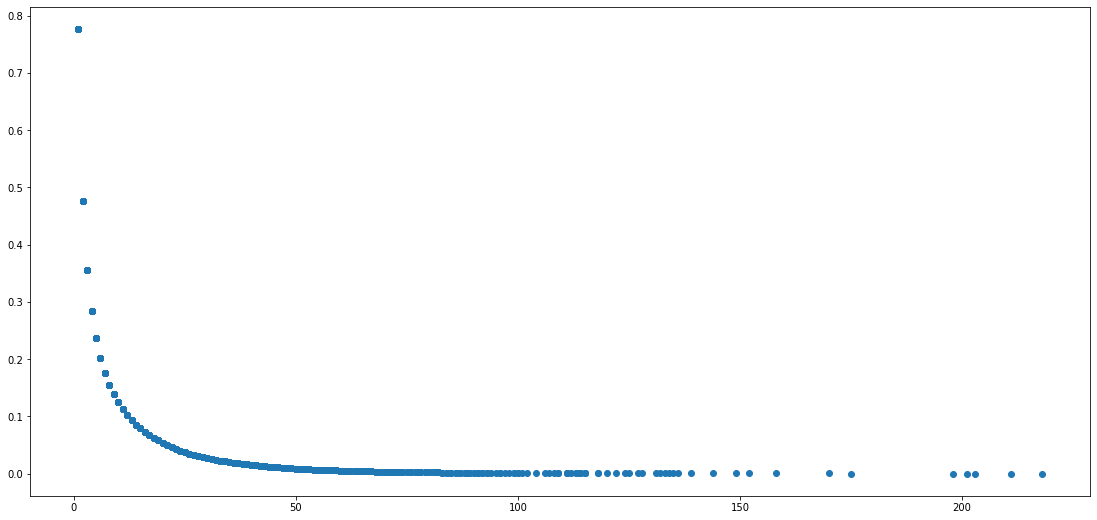

In [ ]:
plt.figure(figsize=(19,9))
plt.scatter(recency_frequecy_mentory_data['frequency'],recency_frequecy_mentory_data['freq_percential'])

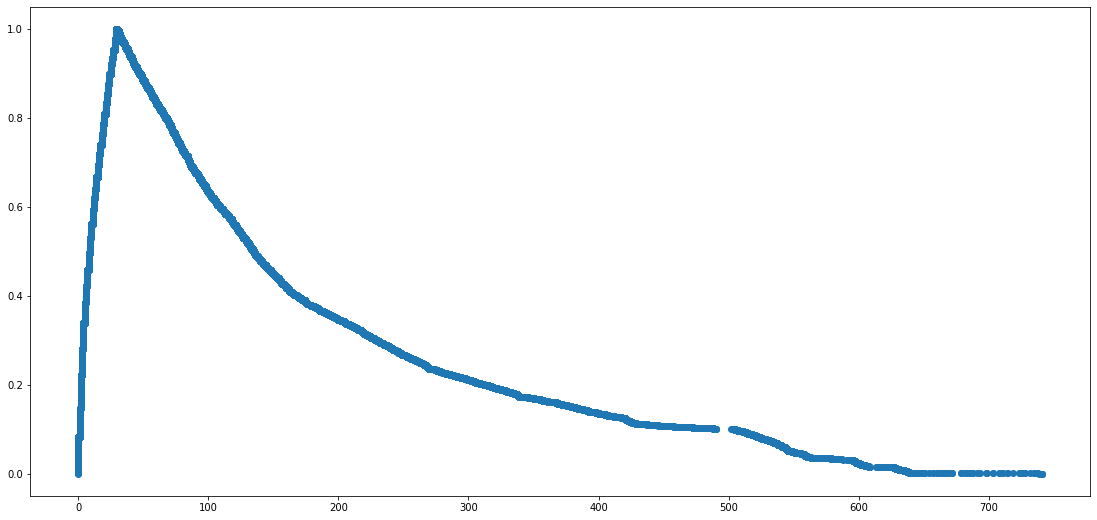

In [ ]:
plt.figure(figsize=
           (19,9))
a=recency_frequecy_mentory_data['Time'].astype('timedelta64[D]')
plt.scatter(a,recency_frequecy_mentory_data['recency_percential'])

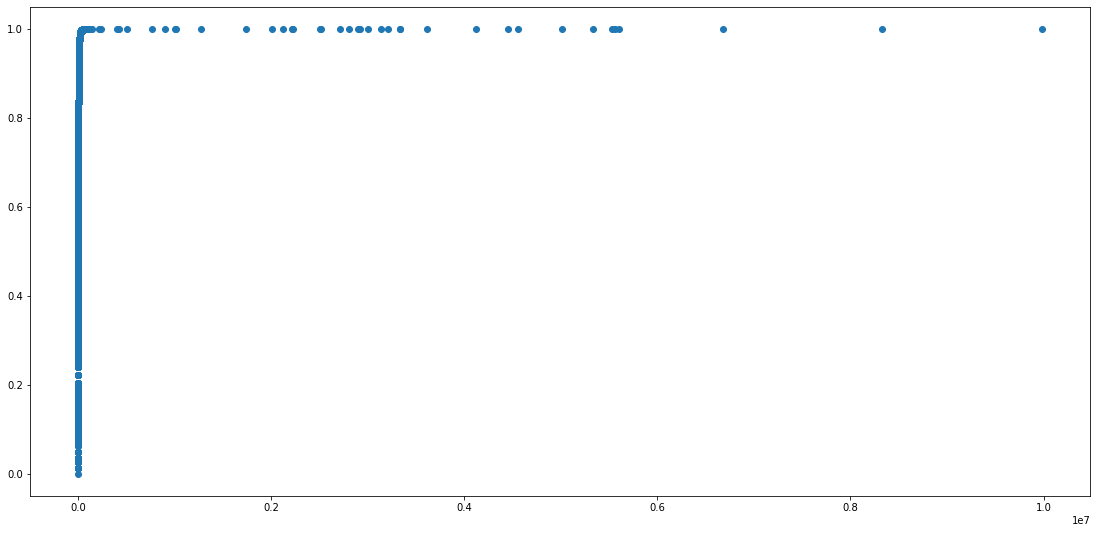

In [ ]:
recency_frequecy_mentory_data.head()

,order_id,address_id,service_area_id,customer_id,customer_phone_no,aceepted_time,Time,recency_percential,frequency,freq_percential,Total_Percential,Total_Percential_2,Mentory,montery_Percential,Total_Percential_4,Total_Percential_3
889,663758,103769,10034,109652,+923111230470,2021-06-27 18:00:16,41 days 03:21:45,0.934368,1,0.776954,0.725961,98.262688,2432.0,0.835291,0.606389,1.000000
3704,586741,83810,10027,135714,+923332509765,2021-05-25 17:14:02,74 days 04:07:59,0.762950,1,0.776954,0.592777,92.761525,2009999.0,0.999491,0.592475,0.999980
1928,639465,100563,10023,167184,+923242330040,2021-06-15 16:33:48,53 days 04:48:13,0.868836,1,0.776954,0.675045,96.232241,3310.0,0.876870,0.591927,0.999961
2200,632868,95640,10046,39330,+923330222952,2021-06-11 21:32:21,56 days 23:49:40,0.852466,1,0.776954,0.662326,95.700690,3375.0,0.879357,0.582421,0.999941
1326,655020,102657,10053,139978,+923342403762,2021-06-22 20:14:58,46 days 01:07:03,0.907374,1,0.776954,0.704988,97.408689,2200.0,0.819666,0.577855,0.999922


In [ ]:
recency_frequecy_mentory_data.shape

(51171, 16)

In [ ]:
recency_frequecy_mentory_data[recency_frequecy_mentory_data['customer_id']==165036]

,order_id,address_id,service_area_id,customer_id,customer_phone_no,aceepted_time,Time,recency_percential,frequency,freq_percential,Total_Percential,Total_Percential_2,Mentory,montery_Percential,Total_Percential_4,Total_Percential_3
51169,780080,104635,22,165036,+923116589868,2021-08-07 18:38:53,0 days 02:43:08,0.021499,201,0.000078,0.000002,0.003908,142260.0,0.999256,0.000002,0.000059


In [ ]:
cursors3=connection.cursor()
cursors3.execute("""
select
BuddyData.IdServiceArea,
ABS(sum(if(BuddyData.status = 1,1,0))) as OnlineBuddy,
ABS(sum(if(BuddyData.status = 2,1,0)))as Offlinebuddy,
ABS(sum(if(BuddyData.status = 3,1,0))) as OnJob
from
(
	select buddy.status,bsa.service_area_id as 'IdServiceArea'
	from buddy
	left join buddy_service_areas bsa on buddy.id = bsa.buddy_id
)as BuddyData
group by 1;""")
rows3=cursors3.fetchall()
data3=pd.DataFrame(rows3)
arra=[]
for col in range(0,len(data3.columns)):
  arra.append(cursors3.description[col][0])

data3.columns=arra

In [ ]:
data3.dropna(inplace=True)
Area=data3[data3['OnlineBuddy']>0]
Area['Invite']=Area['OnlineBuddy']*100/5

In [ ]:
Area

In [ ]:
temp={}
i=0
for x in Area['IdServiceArea']:
  inverUserCount=int(Area[Area['IdServiceArea']==x]['Invite'])
  temp[i]=pd.DataFrame(recency_frequecy_data2[(recency_frequecy_data2['service_area_id']==x)].head(inverUserCount))
  i=i+1


In [ ]:
temp[0]